In [1]:
import seaborn as sns
from nufeb_tools import utils,plot,spatial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.inspection import permutation_importance
import matplotlib.image as mpimg
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from pathlib import Path
from joblib import Parallel, delayed

In [2]:
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

In [3]:
DIR = Path(r'E:\fitness-prediction\runs')
folders = [path for path in DIR.iterdir() if path.is_dir()]

In [4]:
def collect_data(folder):
    
    try:
        a = utils.get_data(directory=str(folder))
        b = spatial.fitness_metrics(a)
        return b
    except:
        print('Error in ' + str(folder))
        return

# Gather datasets

In [2]:
if Path(r'E:\fitness-prediction\saved-metrics.pkl').is_file():
    data = pd.read_pickle(r'E:\fitness-prediction\saved-metrics.pkl')
else:
    with ProgressParallel(n_jobs=6) as parallel:
        temp = parallel(delayed(collect_data)(folder) for folder in sorted(folders))
    data = pd.concat(temp)
    data.to_pickle(r'E:\fitness-prediction\saved-metrics.pkl')





In [6]:
cmaps = ["light:#03012d","light:#d99e09"]
cmaps2 = ["#03012d","#d99e09"]


# IC 1

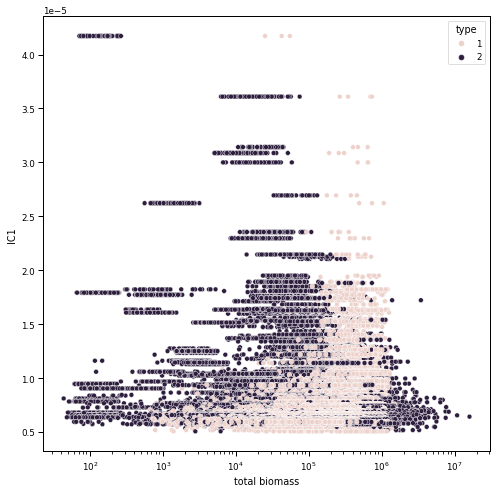

In [7]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IC1',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


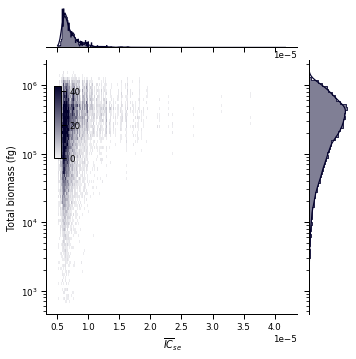

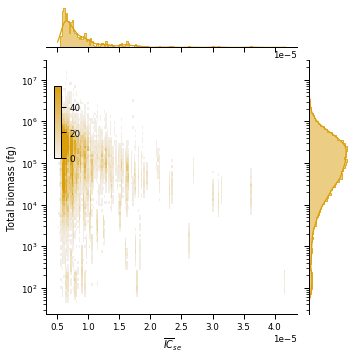

In [8]:
types = [r'$\it{S. elongatus}$',r'$\it{E. coli W}$']
for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IC1",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r' $\overline{IC}_{se}$')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/IC1_{i}.png',dpi=600)

# IC 2

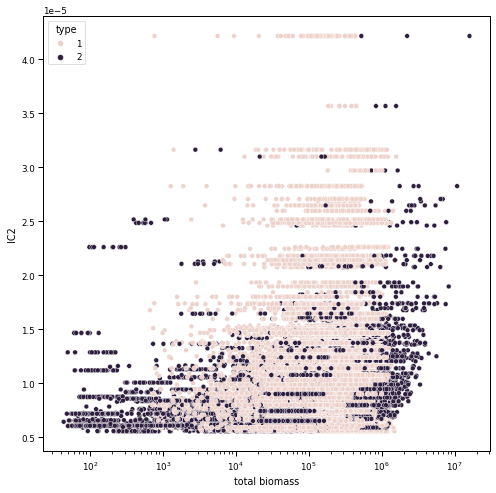

In [9]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IC2',hue='type',data=data,ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()


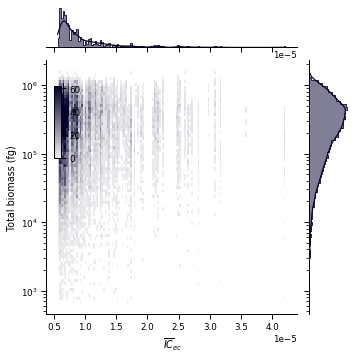

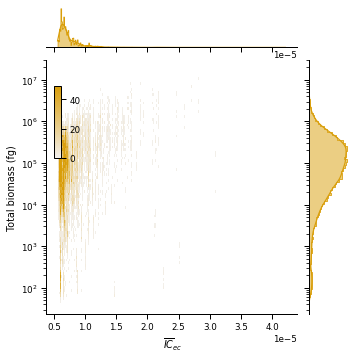

In [10]:
sns.set_context('paper')
for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IC2",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    #g.ax_joint.set(yscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r' $\overline{IC}_{ec}$')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/IC2_{i}.png',dpi=600)

Text(0, 0.5, ' $\\overline{IC}_{ec}$')

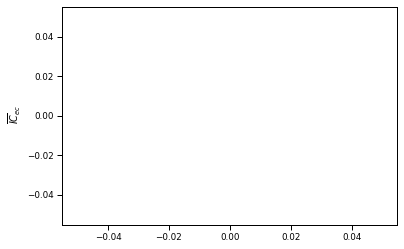

In [11]:
f, ax =plt.subplots()
ax.plot()
ax.set_ylabel(r' $\overline{IC}_{ec}$')


# Sucrose export

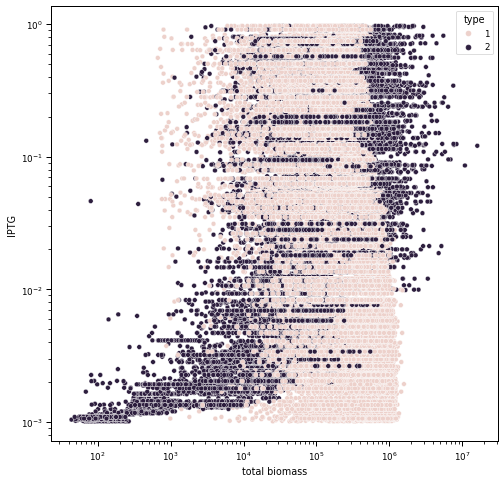

In [12]:
sns.set_context('paper')
f, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x='total biomass',y='IPTG',hue='type',data=data,ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


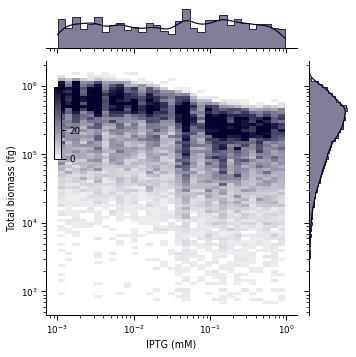

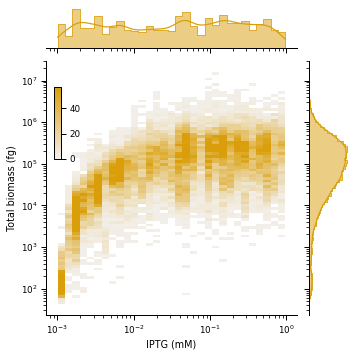

In [13]:

for i in [1,2]:
    data2 = data[data.type==i]
    g = sns.JointGrid(data=data2, x="IPTG",y="total biomass", height=5,space=0.3)
    """     if i==1:
        g.fig.suptitle(r'$\it{S. elongatus}$')
    elif i ==2:
        g.fig.suptitle(r'$\it{E. coli W}$') """
    g.ax_joint.set(yscale="log")
    g.ax_joint.set(xscale="log")
    cax = g.fig.add_axes([.15, .55, .02, .2])
    g.plot_joint(
        sns.histplot, 
        cmap=cmaps[i-1], cbar=True, cbar_ax=cax,pmax=.8)
    g.plot_marginals(sns.histplot, element="step", color=cmaps2[i-1],kde=True)
    g.ax_joint.set_xlabel(r'IPTG (mM)')
    g.ax_joint.set_ylabel('Total biomass (fg)')
    g.savefig(f'../figures/sucR_{i}.png',dpi=600)

In [14]:
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.1, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

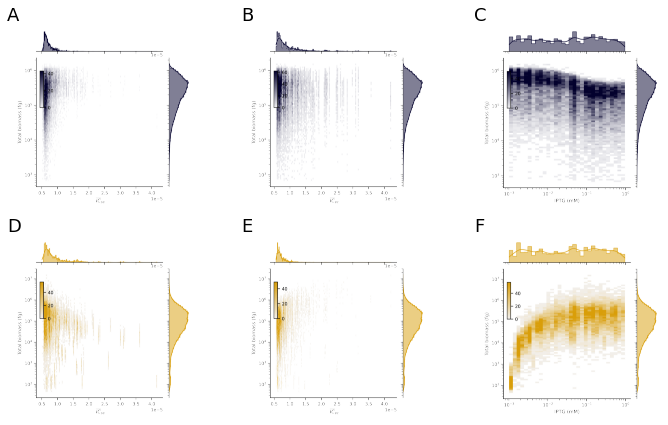

In [15]:
f, axes = plt.subplots(nrows=2,ncols=3,figsize=(10,6))
axes[0,0].imshow(mpimg.imread('../figures/IC1_1.png'))
axes[0,1].imshow(mpimg.imread('../figures/IC2_1.png'))
axes[0,2].imshow(mpimg.imread('../figures/sucR_1.png'))

axes[1,0].imshow(mpimg.imread('../figures/IC1_2.png'))
axes[1,1].imshow(mpimg.imread('../figures/IC2_2.png'))
axes[1,2].imshow(mpimg.imread('../figures/sucR_2.png'))
for ax in axes.ravel():
    ax.axis('off')

label_panel(axes[0,0],'A')
label_panel(axes[0,1],'B')
label_panel(axes[0,2],'C')
label_panel(axes[1,0],'D')
label_panel(axes[1,1],'E')
label_panel(axes[1,2],'F')
f.tight_layout()
f.savefig('../figures/spatial metrics.png',dpi=600)

Score:  1.0
Mean cross-validataion score: 0.22


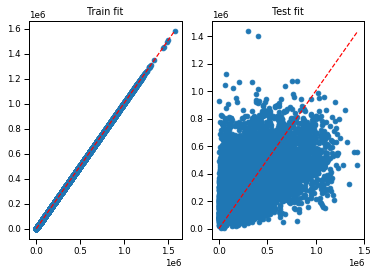

           0         1                         2
2   1.057113  0.011268                      IPTG
6   0.445058   0.00359                       IC1
8   0.154688  0.001481                        IC
13  0.052745  0.000485                        Z2
10  0.050198  0.000434  Relative Neighbor Dist 2
15  0.049675  0.000444                      Z2_1
7   0.042436  0.000471                       IC2
21  0.038047  0.000289                  Log Inv1
16  0.036754  0.000188              LogNearest 1
3   0.033709  0.000298                 Nearest 1
12  0.033562  0.000285                        Z1
14  0.033222  0.000328                      Z1_2
9   0.032825  0.000274  Relative Neighbor Dist 1
11  0.032215  0.000259    Relative Neighbor Dist
4   0.031224  0.000231                 Nearest 2
19  0.029929  0.000157                      Inv1
22  0.027337  0.000148                  Log Inv2
17  0.025616  0.000096              LogNearest 2
5   0.024549  0.000146          Nearest Neighbor
18  0.022156  0.0001

In [16]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 

data2 = data[data.type==1]
X = data2[predictors]
y = data2['total biomass']
train_X1, test_X1, train_y1, test_y1 = train_test_split(X, y, train_size = 0.7, random_state = 42)

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et1 = ExtraTreesRegressor(n_estimators=500, random_state=100,n_jobs=-1)
model_et1.fit(train_X1, train_y1) 

pred_train_et1= model_et1.predict(train_X1)
pred_test_et1 = model_et1.predict(test_X1)

score = model_et1.score(train_X1, train_y1)
print("Score: ", score)
cv_scores = cross_val_score(model_et1, train_X1,train_y1,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y1,pred_train_et1)
axes[1].scatter(test_y1,pred_test_et1)
#Plot the diagonal line
d_line= np.arange(train_y1.min(), train_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y1.min(), test_y1.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

result1 = permutation_importance(model_et1, train_X1, train_y1, random_state=0)
feats1 = pd.DataFrame([result1.importances_mean,result1.importances_std,X.columns]).T
print(feats1.sort_values(by=0,ascending=False))

Score:  1.0
Mean cross-validataion score: 0.22


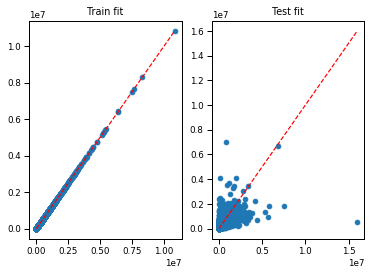

' result2 = permutation_importance(model_et2, train_X2, train_y2, random_state=0)\nfeats2 = pd.DataFrame([result2.importances_mean,result2.importances_std,X.columns]).T\nprint(feats2.sort_values(by=0,ascending=False)) '

In [17]:
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X2, test_X2, train_y2, test_y2 = train_test_split(X, y, train_size = 0.7, random_state = 42)

#model_et = ExtraTreesRegressor(n_estimators=500, random_state=100,max_features=6,max_depth=50,bootstrap=True,n_jobs=-1)
model_et2 = ExtraTreesRegressor(n_estimators=1000, random_state=100,n_jobs=-1)
model_et2.fit(train_X2, train_y2) 

pred_train_et2= model_et2.predict(train_X2)
pred_test_et2 = model_et2.predict(test_X2)

score2 = model_et2.score(train_X2, train_y2)
print("Score: ", score)
cv_scores2 = cross_val_score(model_et2, train_X2,train_y2,cv=3)
print("Mean cross-validataion score: %.2f" % cv_scores.mean())
f, axes = plt.subplots(ncols=2)
axes[0].scatter(train_y2,pred_train_et2)
axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(train_y2.min(), train_y2.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_title('Train fit')
axes[1].set_title('Test fit')
plt.show()
#feats = pd.DataFrame([model_et.feature_importances_,X.columns]).T
#print(feats.sort_values(by=0,ascending=False))

""" result2 = permutation_importance(model_et2, train_X2, train_y2, random_state=0)
feats2 = pd.DataFrame([result2.importances_mean,result2.importances_std,X.columns]).T
print(feats2.sort_values(by=0,ascending=False)) """

In [18]:
r2_score(test_y2,pred_test_et2)

0.2822884097707523

In [5]:
predictors = list(data.columns.drop(['total biomass','Colony Area','mother_cell'])) 
data2 = data[data.type==2]
X = data2[predictors]
y = data2['total biomass']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size = 0.9, random_state = 42)

In [8]:

from sklearn.model_selection import GridSearchCV
n_samples = X.shape[0]
n_features = X.shape[1]
params = {'n_estimators': [100,1000],
          'max_depth': [None, 2,5,],
          'min_samples_split': [2, 0.5, n_samples//2, ],
          'min_samples_leaf': [1, 0.5, n_samples//2, ],
          'criterion': ['mse', 'mae'],
          'max_features': [None, 'sqrt', 'auto', 'log2', 0.3],
          'bootstrap':[True, False]
         }

ef_regressor_grid = GridSearchCV(ExtraTreesRegressor(random_state=1), param_grid=params, n_jobs=-1, cv=3, verbose=1)
ef_regressor_grid.fit(train_X, train_y)

print('Train R^2 Score : %.3f'%ef_regressor_grid.best_estimator_.score(train_X, train_y))
print('Test R^2 Score : %.3f'%ef_regressor_grid.best_estimator_.score(test_X, test_y))
print('Best R^2 Score Through Grid Search : %.3f'%ef_regressor_grid.best_score_)
print('Best Parameters : ',ef_regressor_grid.best_params_)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Train R^2 Score : 0.917
Test R^2 Score : 0.396
Best R^2 Score Through Grid Search : 0.399
Best Parameters :  {'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


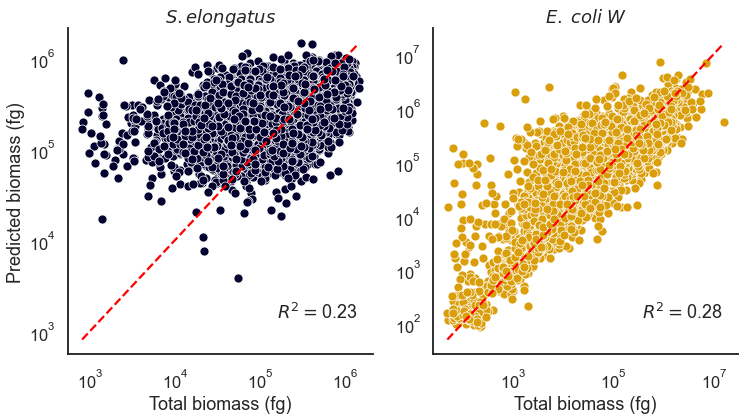

In [19]:
sns.set_theme(style="white")
sns.set_context('talk')
cmaps2 = ["#03012d","#d99e09"]
r2s = [r2_score(test_y1,pred_test_et1),r2_score(test_y2,pred_test_et2)]
f, axes = plt.subplots(ncols=2,figsize=(12,6))
#axes[0].scatter(test_y1,pred_test_et1)
sns.scatterplot(x=test_y1,y=pred_test_et1,ax=axes[0],color="#03012d")
sns.scatterplot(x=test_y2,y=pred_test_et2,ax=axes[1],color="#d99e09")
#axes[1].scatter(test_y2,pred_test_et2)
#Plot the diagonal line
d_line= np.arange(test_y1.min(), test_y1.max())
axes[0].plot(d_line, d_line, color='red', linestyle='--')
d_line= np.arange(test_y2.min(), test_y2.max())
axes[1].plot(d_line, d_line, color='red', linestyle='--')
axes[0].set_ylabel('Predicted biomass (fg)')
for r2,ax in zip(r2s,axes.ravel()):
    ax.set_xlabel('Total biomass (fg)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(0.95,0.1,f'$R^2=${r2:.2f}',transform=ax.transAxes,verticalalignment='bottom', horizontalalignment='right')
axes[0].set_title(r'$\it{S. elongatus}$')
axes[1].set_title(r'$\it{E.}$ $\it{coli}$ $\it{W}$')
sns.despine()
#f.savefig('../figures/biomass-prediction.pdf',bbox_inches='tight')